In [37]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
diab_df=pd.read_csv('diabetic_data.csv')
diab_df.shape


(101766, 50)

In [38]:
diab_df.replace('?',np.nan,inplace=True)
diab_df = diab_df[diab_df.isnull().sum(axis=1) < 2]
diab_df.shape
diab_df=diab_df[1:5000]
diab_df.replace(np.nan,'Missing',inplace=True)

In [39]:
import re 
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score,precision_recall_fscore_support,classification_report
import xgboost as xgb
from sklearn.model_selection import cross_val_score
le = LabelEncoder()
ohe = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
mmscaler = MinMaxScaler()
sscaler = StandardScaler()
import warnings
warnings.filterwarnings("ignore")

In [40]:
def transform_diagnosis(df,target, column):

    diab_df[column] = diab_df[target]
    diab_df.loc[diab_df[target].str.contains('V',na=False), [column]] = 1000
    diab_df.loc[diab_df[target].str.contains('E',na=False), [column]] = 1000
    diab_df.loc[diab_df[target].str.contains('250',na=False), [column]] = 2500
    diab_df[column].replace('Missing',-1,inplace=True)
    diab_df[column] = diab_df[column].astype(float)
    diab_df[column][((diab_df[column]>=390) & (diab_df[column]<460)) | (diab_df[column]==785)] = 1001
    diab_df[column][((diab_df[column]>=460) & (diab_df[column]<520)) | (diab_df[column]==786)] = 1002
    diab_df[column][((diab_df[column]>=520) & (diab_df[column]<580)) | (diab_df[column]==787)] = 1003
    diab_df[column][((diab_df[column]>=800) & (diab_df[column]<1000))] = 1005
    diab_df[column][((diab_df[column]>=710) & (diab_df[column]<740))] = 1006
    diab_df[column][((diab_df[column]>=580) & (diab_df[column]<630)) | (diab_df[column]==788)] = 1007
    diab_df[column][((diab_df[column]>=140) & (diab_df[column]<240))] = 1008
    diab_df[column][((diab_df[column]>=0) & (diab_df[column]<1000))] = 1000
    diab_df[column].replace(1001,'Circulatory',inplace=True)
    diab_df[column].replace(1002,'Respiratory',inplace=True)
    diab_df[column].replace(1003,'Digestive',inplace=True)
    diab_df[column].replace(2500,'Digestive',inplace=True)
    diab_df[column].replace(1005,'Injury',inplace=True)
    diab_df[column].replace(1006,'Musculoskeletal',inplace=True)
    diab_df[column].replace(1007,'Genitourinary',inplace=True)
    diab_df[column].replace(1008,'Neoplasms',inplace=True)
    diab_df[column].replace(1000,'Other',inplace=True)
    diab_df[column].replace(-1,'Missing',inplace=True)

In [41]:
def trans_variables():
    diab_df.drop(['weight','payer_code'],1,inplace=True)
    diab_df.drop(['examide','citoglipton'],1,inplace=True)  
    diab_df.diag_1.replace('?','Missing',inplace=True)
    diab_df.diag_2.replace('?','Missing',inplace=True)
    diab_df.diag_3.replace('?','Missing',inplace=True)
    transform_diagnosis(diab_df, 'diag_1','diag_1_group')
    transform_diagnosis(diab_df, 'diag_2','diag_2_group')
    transform_diagnosis(diab_df, 'diag_3','diag_3_group')
    diab_df.drop(['diag_1','diag_2','diag_3'],1,inplace=True)
    diab_df['admission_type_id'] = diab_df['admission_type_id'].astype(str)
    diab_df['discharge_disposition_id'] = diab_df['discharge_disposition_id'].astype(str)
    diab_df['admission_source_id'] = diab_df['admission_source_id'].astype(str)
    diab_df['readmitted'] = diab_df['readmitted'].replace('>30', 0)
    diab_df['readmitted'] = diab_df['readmitted'].replace('<30', 1)
    diab_df['readmitted'] = diab_df['readmitted'].replace('NO', 0)
    diab_df.change.replace('No',0,inplace=True)
    diab_df.change.replace('Ch',1,inplace=True)
    diab_df.diabetesMed.replace('No',0,inplace=True)
    diab_df.diabetesMed.replace('Yes',1,inplace=True)
    diab_df.replace('?','Missing',inplace=True)
    temp_df=diab_df.groupby('patient_nbr')['encounter_id'].min().reset_index()
    temp_df = pd.merge(temp_df,diab_df.drop('patient_nbr',1),'left',left_on='encounter_id',right_on='encounter_id')
    temp_df = temp_df[~temp_df['discharge_disposition_id'].isin([11,13,14,19,20,21])]
    temp_df.drop('patient_nbr',1,inplace=True)
    temp_df.drop('encounter_id',1,inplace=True)
    return temp_df

In [42]:
feature_names=['race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed',
       'diag_1_group', 'diag_2_group', 'diag_3_group']
temp_df=trans_variables()      
X = temp_df[feature_names]
y = temp_df['readmitted']

In [46]:
def ML_pipeline_kfold_l1(X,y,random_state,n_folds):
    
    ## Split your data in a stratified manner, 5 stratified folds.
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state, stratify = y)
    CV_scores = []
    test_scores = []
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    
    # You'll need to loop through the 5 options the CV fold can be selected
    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other.iloc[train_index], X_other.iloc[CV_index]
        y_train, y_CV = y_other.iloc[train_index], y_other.iloc[CV_index]
        
        target = ['readmitted']
        num_ftrs =['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']
        ohe_ftrs = ['race','gender','age','medical_specialty','max_glu_serum','A1Cresult','metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone','diag_1_group','diag_2_group','diag_3_group']
        bin_ord_ftrs = ['change', 'diabetesMed','admission_type_id','discharge_disposition_id', 'admission_source_id']
        
        ## Preprocess the data
        ## We don't want to apply one hot to binary var
        X_train_num = sscaler.fit_transform(X_train[num_ftrs])
        X_c_num = sscaler.transform(X_CV[num_ftrs])
        X_t_num = sscaler.transform(X_test[num_ftrs])
        
        X_train_cat = ohe.fit_transform(X_train[ohe_ftrs])
        X_c_cat = ohe.transform(X_CV[ohe_ftrs])
        X_t_cat = ohe.transform(X_test[ohe_ftrs])

        X_train = np.concatenate((X_train_cat,X_train_num, np.array(X_train[bin_ord_ftrs])),axis=1)
        X_c = np.concatenate((X_c_cat,X_c_num, np.array(X_CV[bin_ord_ftrs])),axis=1)
        X_t = np.concatenate((X_t_cat,X_t_num, np.array(X_test[bin_ord_ftrs])),axis=1)
        
       
        # tune lasso hyper-parameter, alpha
        alpha = np.logspace(-5,5,num = 5)
        train_score = []
        CV_score = []
        regs = []
        f1_scores=[]
        for a in alpha:
            reg = LogisticRegression(penalty='l1',C = 1/a, multi_class = 'auto', 
                                     solver='saga', max_iter = 1e4)
            reg.fit(X_train,y_train)
            train_score.append(f1_score(y_train,reg.predict(X_train)))
            CV_score.append(f1_score(y_CV,reg.predict(X_c)))
            regs.append(reg)
        # find the best alpha in this fold
        best_alpha = alpha[np.argmax(CV_score)]
        # grab the best model
        reg = regs[np.argmax(CV_score)]
        CV_scores.append(np.max(CV_score))
        # calculate test score using thee best model
        test_scores.append(accuracy_score(y_test,reg.predict(X_t)))
        f1_scores.append(f1_score(y_test,reg.predict(X_t)))
        fbeta_score=classification_report(y_test, reg.predict(X_t))
    return reg,f1_scores,test_scores,best_alpha,fbeta_score

In [34]:
testscores = []
fbetascores=[]

for i in range(1,5):
    grid, f1_scores,test_scores, best_alpha,fbeta_score= ML_pipeline_kfold_l1(X,y,42*i,5)
    testscores.append(test_scores)
    fbetascores.append(fbeta_score)
    print("The best alpha of the {}th time:".format(i), best_alpha)
print(pd.DataFrame(fbetascores))
print('test score:',np.around(np.mean(testscores),2), '+/-', np.around(np.std(testscores),2))
#print('f1 score:',np.around(np.mean(fbetascores),2), '+/-', np.around(np.std(fbetascores),2))

KeyError: "None of [Index(['race', 'gender', 'age', 'medical_specialty', 'max_glu_serum',\n       'A1Cresult', 'metformin', 'pioglitazone', 'troglitazone', 'tolazamide',\n       'insulin', 'metformin-pioglitazone', 'diag_1_group', 'diag_2_group',\n       'diag_3_group'],\n      dtype='object')] are in the [columns]"

In [51]:
fbetascores

['              precision    recall  f1-score   support\n\n           0       0.91      0.99      0.95       801\n           1       0.17      0.01      0.02        77\n\n    accuracy                           0.91       878\n   macro avg       0.54      0.50      0.49       878\nweighted avg       0.85      0.91      0.87       878\n',
 '              precision    recall  f1-score   support\n\n           0       0.91      1.00      0.95       801\n           1       0.33      0.01      0.03        77\n\n    accuracy                           0.91       878\n   macro avg       0.62      0.51      0.49       878\nweighted avg       0.86      0.91      0.87       878\n',
 '              precision    recall  f1-score   support\n\n           0       0.91      1.00      0.95       801\n           1       0.00      0.00      0.00        77\n\n    accuracy                           0.91       878\n   macro avg       0.46      0.50      0.48       878\nweighted avg       0.83      0.91      0.

In [ ]:
# print the ROC curve

In [7]:
target = ['readmitted']
num_ftrs =['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']
ohe_ftrs = ['race','gender','age','medical_specialty','max_glu_serum','A1Cresult','metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone','diag_1_group','diag_2_group','diag_3_group']
bin_ord_ftrs = ['change', 'diabetesMed','admission_type_id','discharge_disposition_id', 'admission_source_id']
X_onehot=X[ohe_ftrs].copy()
ohe.fit(X_onehot)
column_name =ohe.get_feature_names(ohe_ftrs)
X_onehot=ohe.transform(X_onehot)
X_onehot=pd.DataFrame(X_onehot, columns = column_name)

X_std=X[num_ftrs].copy()
X_std= sscaler.fit_transform(X_std)
X_std = pd.DataFrame(X_std, columns = num_ftrs)
X_std = X_std[num_ftrs]
# from sklearn import preprocessing
# lbl = preprocessing.LabelEncoder()
# X[bin_ord_ftrs] = lbl.fit_transform(X[bin_ord_ftrs].astype(int))
from sklearn.preprocessing import LabelEncoder
for i in (bin_ord_ftrs):
    
    x_le=X[i].copy()
    le = LabelEncoder()
    x_le=le.fit_transform(x_le)
    x_le = pd.DataFrame(x_le, columns = [i])
    X[i] = x_le[i]


stack = pd.concat([X_onehot,X_std], axis=1)
X = pd.concat([stack, X[bin_ord_ftrs]], axis=1)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

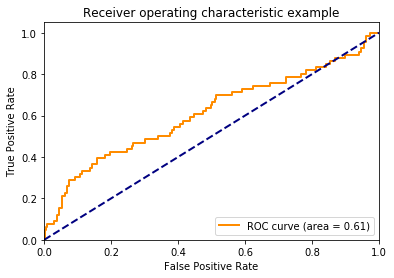

In [29]:
x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(X, y,test_size=0.2, random_state=0)
from sklearn.linear_model import LogisticRegression
LR_up = LogisticRegression(class_weight='balanced',)
LR_up.fit(x_train_lr, y_train_lr)
y_predict_up = LR_up.predict(x_test_lr)
LR_up.set_params(C=1e-05,penalty='l1')
y_probs_lr = pd.DataFrame(LR_up.predict_proba(x_test_lr))[1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_lr, y_probs_lr)
auc_lr = roc_auc_score(y_test_lr, y_probs_lr)
plt.figure()
lw = 2
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Random forest 

In [15]:
x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(X, y,test_size=0.2, random_state=0)
model=ensemble.RandomForestClassifier()
grid_para_forest = [{
    "n_estimators": [300,400,500],
    "max_depth":(30,40),
    "min_samples_leaf":[1,2,3,4,5],
    "min_samples_split":[2,3],
    "random_state": [42]}]
grid_search_forest = GridSearchCV(model, grid_para_forest, cv=5,scoring='roc_auc')
grid_search_forest.fit(x_train_lr, y_train_lr)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [17]:
bestparam= grid_search_forest.best_params_
bestscore= grid_search_forest.best_score_
model_1 = ensemble.RandomForestClassifier(**bestparam)
model_1.fit(x_train_lr,y_train_lr)
train_score=model_1.score(x_train_lr,y_train_lr)
test_score=model_1.score(x_test_lr, y_test_lr)

In [28]:
y_pr_rf=model_1.predict(x_test_lr)
precision_recall_fscore_support(y_test_lr,y_pr_rf)
# Output is:
# [Precision of class 0, Precision of class 1]
# [Recall of class 0   , Recall of class 1]
# [F1 Score of class 0 , F1 Score of class 1]
# [Instances of class 0, Instances of class 1]

(array([0.92482916, 0.        ]),
 array([1., 0.]),
 array([0.96094675, 0.        ]),
 array([812,  66]))

<Figure size 720x1080 with 0 Axes>

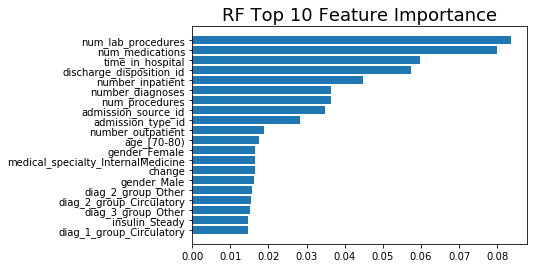

<Figure size 720x1080 with 0 Axes>

In [38]:
sorted_importance_rf = sorted(zip(X.columns, model_1.feature_importances_), key=lambda t:t[1], reverse=True)
plt.barh([x[0] for x in sorted_importance_rf[:20]][::-1],[x[1] for x in sorted_importance_rf[:20]][::-1])
plt.title('RF Top 10 Feature Importance', fontsize=18)
plt.figure(figsize=(10,15))

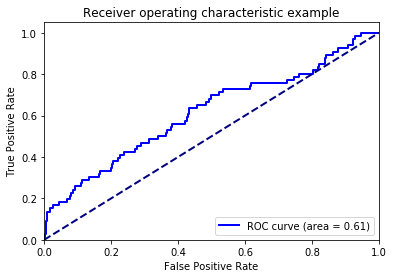

In [37]:
y_probs_rf = pd.DataFrame(model_1.predict_proba(x_test_lr))[1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_lr, y_probs_rf)
auc_rf = roc_auc_score(y_test_lr, y_probs_rf)
plt.figure()
lw = 2
plt.plot(fpr_rf, tpr_rf, color='blue', lw=lw, label='ROC curve (area = %0.2f)' % auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

xgboost 

In [8]:
x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(X, y,test_size=0.2, random_state=0)

In [11]:
xgb=xgb.XGBClassifier()
grid_para_xgboost =[{
    "eta": (0.001,0.4),
    "gamma":(0,20),
    "max_depth":(2,20)}]
grid_search_xgboost = GridSearchCV(xgb, grid_para_xgboost, cv=5,scoring='roc_auc')
grid_search_xgboost.fit(x_train_lr, y_train_lr)


AttributeError: 'XGBClassifier' object has no attribute 'XGBClassifier'

In [10]:
#bestparam= grid_search_xgboost.best_params_
#bestscore= grid_search_xgboost.best_score_
xgboost_1 = xgb.XGBClassifier(eta=0.001,
             gamma=0,
             max_depth=2, 
             n_jobs=-1, 
             random_state=42,   
             class_weight="balanced")
xgboost_1.fit(x_train_lr,y_train_lr)
xgboost_1.score(x_train_lr,y_train_lr)
xgboost_1.score(x_test_lr, y_test_lr)

0.9259681093394078

In [29]:
y_pr_xg=xgboost_1.predict(x_test_lr)
precision_recall_fscore_support(y_test_lr,y_pr_xg)

(array([0.92588369, 1.        ]),
 array([1.        , 0.01515152]),
 array([0.96151569, 0.02985075]),
 array([812,  66]))

Text(0.5, 1.0, 'XGB Top 10 Feature Importance')

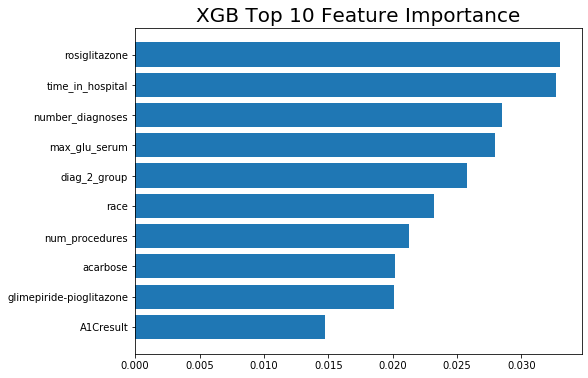

In [48]:
plt.figure(figsize=(8,6))
sorted_importance_xgb = sorted(zip(X.columns, xgboost_1.feature_importances_), key=lambda t:t[1], reverse=True)
plt.barh([x[0] for x in sorted_importance_xgb[:10]][::-1],[x[1] for x in sorted_importance_xgb[:10]][::-1])
plt.title('XGB Top 10 Feature Importance', fontsize=20)


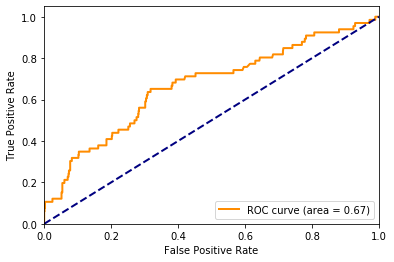

In [13]:
y_probs_xgb = pd.DataFrame(xgboost_1.predict_proba(x_test_lr))[1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test_lr, y_probs_xgb)
auc_xgb = roc_auc_score(y_test_lr, y_probs_xgb)
plt.figure()
lw = 2
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


Use new data set with feature engineering

In [43]:
def ML_pipeline_kfold_l1(X,y,random_state,n_folds):
    
    ## Split your data in a stratified manner, 5 stratified folds.
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state, stratify = y)
    CV_scores = []
    test_scores = []
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    
    # You'll need to loop through the 5 options the CV fold can be selected
    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other.iloc[train_index], X_other.iloc[CV_index]
        y_train, y_CV = y_other.iloc[train_index], y_other.iloc[CV_index]
        
        target = ['readmitted']
        num_ftrs =['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']
        ohe_ftrs = ['race','gender','age','medical_specialty','max_glu_serum','A1Cresult','metformin', 
        'pioglitazone',
       'troglitazone', 'tolazamide', 'insulin',
       'metformin-pioglitazone','diag_1_group','diag_2_group','diag_3_group']
        bin_ord_ftrs = ['change', 'diabetesMed','admission_type_id','discharge_disposition_id', 'admission_source_id']
        
        ## Preprocess the data
        ## We don't want to apply one hot to binary var
        X_train_num = sscaler.fit_transform(X_train[num_ftrs])
        X_c_num = sscaler.transform(X_CV[num_ftrs])
        X_t_num = sscaler.transform(X_test[num_ftrs])
        
        X_train_cat = ohe.fit_transform(X_train[ohe_ftrs])
        X_c_cat = ohe.transform(X_CV[ohe_ftrs])
        X_t_cat = ohe.transform(X_test[ohe_ftrs])

        X_train = np.concatenate((X_train_cat,X_train_num, np.array(X_train[bin_ord_ftrs])),axis=1)
        X_c = np.concatenate((X_c_cat,X_c_num, np.array(X_CV[bin_ord_ftrs])),axis=1)
        X_t = np.concatenate((X_t_cat,X_t_num, np.array(X_test[bin_ord_ftrs])),axis=1)
        
       
        # tune lasso hyper-parameter, alpha
        alpha = np.logspace(-5,5,num = 5)
        train_score = []
        CV_score = []
        regs = []
        f1_scores=[]
        for a in alpha:
            reg = LogisticRegression(penalty='l1',C = 1/a, multi_class = 'auto', 
                                     solver='saga', max_iter = 1e4)
            reg.fit(X_train,y_train)
            train_score.append(f1_score(y_train,reg.predict(X_train)))
            CV_score.append(f1_score(y_CV,reg.predict(X_c)))
            regs.append(reg)
        # find the best alpha in this fold
        best_alpha = alpha[np.argmax(CV_score)]
        # grab the best model
        reg = regs[np.argmax(CV_score)]
        CV_scores.append(np.max(CV_score))
        # calculate test score using thee best model
        test_scores.append(accuracy_score(y_test,reg.predict(X_t)))
        f1_scores.append(f1_score(y_test,reg.predict(X_t)))
        fbeta_score=classification_report(y_test, reg.predict(X_t))
    return reg,f1_scores,test_scores,best_alpha,fbeta_score

In [44]:
testscores = []
fbetascores=[]

for i in range(1,5):
    grid, f1_scores,test_scores, best_alpha,fbeta_score= ML_pipeline_kfold_l1(X,y,42*i,5)
    testscores.append(test_scores)
    fbetascores.append(fbeta_score)
    print("The best alpha of the {}th time:".format(i), best_alpha)
print(pd.DataFrame(fbetascores))
print('test score:',np.around(np.mean(testscores),2), '+/-', np.around(np.std(testscores),2))
#print('f1 score:',np.around(np.mean(fbetascores),2), '+/-', np.around(np.std(fbetascores),2))

The best alpha of the 1th time: 1.0
The best alpha of the 2th time: 1e-05
The best alpha of the 3th time: 1e-05
The best alpha of the 4th time: 1e-05
                                                   0
0                precision    recall  f1-score   ...
1                precision    recall  f1-score   ...
2                precision    recall  f1-score   ...
3                precision    recall  f1-score   ...
test score: 0.91 +/- 0.0
